In [1]:
from io import open
import glob
import os


def findFiles(path):
    return glob.glob(path)


print(findFiles("data/names/*.txt"))

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

print(f"{all_letters=};\n{n_letters=}")

all_letters="abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'";
n_letters=57


In [3]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return "".join(
        c
        for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn" and c in all_letters
    )


print(unicodeToAscii("Ślusàrski"))

Slusarski


In [4]:
# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []


# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding="utf-8").read().strip().split("\n")
    return [unicodeToAscii(line) for line in lines]


for filename in findFiles("data/names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    print(f"{category=}")
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(f"{n_categories=}")

category='Czech'
category='German'
category='Arabic'
category='Japanese'
category='Chinese'
category='Vietnamese'
category='Russian'
category='French'
category='Irish'
category='English'
category='Spanish'
category='Greek'
category='Italian'
category='Portuguese'
category='Scottish'
category='Dutch'
category='Korean'
category='Polish'
n_categories=18


In [5]:
print(category_lines["Italian"][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [6]:
import torch


# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)


# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor


# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


print(letterToTensor("J"))

print(lineToTensor("Jones").size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [7]:
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.h2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
print(f"{n_letters=}; {n_hidden=}; {n_categories=}")

n_letters=57; n_hidden=128; n_categories=18


In [8]:
input = letterToTensor("A")
print(f"{input.size()=}; {input=}")

hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
print(f"{output.size()=}; {output=}")
print(f"{next_hidden.size()=}; {next_hidden=}")

input.size()=torch.Size([1, 57]); input=tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
output.size()=torch.Size([1, 18]); output=tensor([[-2.8324, -2.8860, -2.8474, -2.9499, -2.9435, -2.9335, -2.8908, -2.9264,
         -2.9457, -2.9145, -2.8961, -2.8749, -2.8081, -2.9030, -2.8830, -2.8145,
         -2.9300, -2.8638]], grad_fn=<LogSoftmaxBackward0>)
next_hidden.size()=torch.Size([1, 128]); next_hidden=tensor([[ 0.0636,  0.0698,  0.0516, -0.0640, -0.0514, -0.0602,  0.0074,  0.0635,
          0.1056,  0.0640,  0.0468,  0.0279, -0.0685, -0.0040, -0.0269,  0.0324,
         -0.0676,  0.0116, -0.0855, -0.0858,  0.0755, -0.0112, -0.0118, -0.0174,
         -0.0610, -0.0208,  0.1408,  0.0308, -0.0478, -0.0262,  0.0222, -0.0954,
          0.0987,  0.0412, -0.0242, -0.0218, -0.0213,

In [9]:
input = lineToTensor("Albert")
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8324, -2.8860, -2.8474, -2.9499, -2.9435, -2.9335, -2.8908, -2.9264,
         -2.9457, -2.9145, -2.8961, -2.8749, -2.8081, -2.9030, -2.8830, -2.8145,
         -2.9300, -2.8638]], grad_fn=<LogSoftmaxBackward0>)


In [10]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1) # returns tuple(values, indices)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


print(categoryFromOutput(output))

('Italian', 12)


In [11]:
import random


def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]


def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor


for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print("category =", category, "/ line =", line)
    print(f"{category_tensor.size()=}; {category_tensor=}")
    print(f"{line_tensor.size()=}")
    print("-----------------------------------------")

category = Korean / line = Choe
category_tensor.size()=torch.Size([1]); category_tensor=tensor([16])
line_tensor.size()=torch.Size([4, 1, 57])
-----------------------------------------
category = Czech / line = Kasa
category_tensor.size()=torch.Size([1]); category_tensor=tensor([0])
line_tensor.size()=torch.Size([4, 1, 57])
-----------------------------------------
category = Polish / line = Niemczyk
category_tensor.size()=torch.Size([1]); category_tensor=tensor([17])
line_tensor.size()=torch.Size([8, 1, 57])
-----------------------------------------
category = Italian / line = Caito
category_tensor.size()=torch.Size([1]); category_tensor=tensor([12])
line_tensor.size()=torch.Size([5, 1, 57])
-----------------------------------------
category = Russian / line = Adamyants
category_tensor.size()=torch.Size([1]); category_tensor=tensor([6])
line_tensor.size()=torch.Size([9, 1, 57])
-----------------------------------------
category = Scottish / line = Mclaughlin
category_tensor.size()=tor

In [12]:
criterion = nn.NLLLoss()

In [13]:
learning_rate = (
    0.005  # If you set this too high, it might explode. If too low, it might not learn
)


def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [14]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = "✓" if guess == category else "✗ (%s)" % category
        print(
            "%d %d%% (%s) %.4f %s / %s %s"
            % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct)
        )

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 2s) 2.1325 Salucci / Italian ✓
10000 10% (0m 4s) 2.5328 Nifterik / Russian ✗ (Dutch)
15000 15% (0m 7s) 1.1788 Hishida / Japanese ✓
20000 20% (0m 9s) 2.3092 Herrmann / Irish ✗ (German)
25000 25% (0m 11s) 0.2836 Bukowski / Polish ✓
30000 30% (0m 14s) 2.1684 Vaca / Spanish ✗ (Czech)
35000 35% (0m 16s) 2.0170 Fields / Greek ✗ (English)
40000 40% (0m 18s) 2.3522 Bran / Chinese ✗ (Irish)
45000 45% (0m 21s) 0.0490 Sklavenitis / Greek ✓
50000 50% (0m 23s) 2.0851 Heidrich / English ✗ (German)
55000 55% (0m 26s) 2.3886 Rettig / Czech ✗ (German)
60000 60% (0m 28s) 2.1575 Rhee / Irish ✗ (Korean)
65000 65% (0m 30s) 0.7135 Connolly / Irish ✓
70000 70% (0m 33s) 1.2837 Heel / German ✗ (Dutch)
75000 75% (0m 35s) 0.3171 Robertson / Scottish ✓
80000 80% (0m 38s) 0.2480 Man / Chinese ✓
85000 85% (0m 40s) 0.1447 Romijnsen / Dutch ✓
90000 90% (0m 42s) 1.1608 Dardyk / Czech ✗ (Russian)
95000 95% (0m 45s) 0.0241 Hasbulatov / Russian ✓
100000 100% (0m 47s) 2.3827 Lee / Chinese ✗ (Korean)


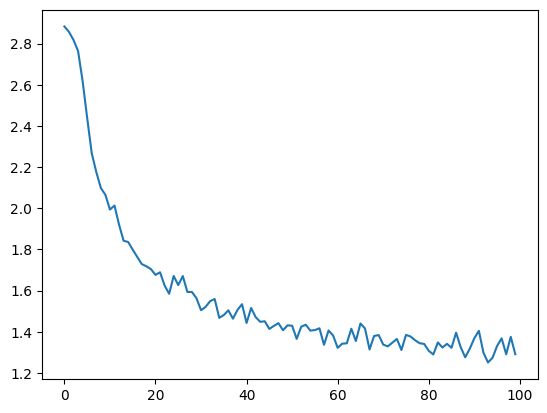

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/var/folders/62/sqk699ld69v13ny7hdx8n4980000gn/T/ipykernel_29472/2887250372.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + all_categories, rotation=90)
/var/folders/62/sqk699ld69v13ny7hdx8n4980000gn/T/ipykernel_29472/2887250372.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + all_categories)


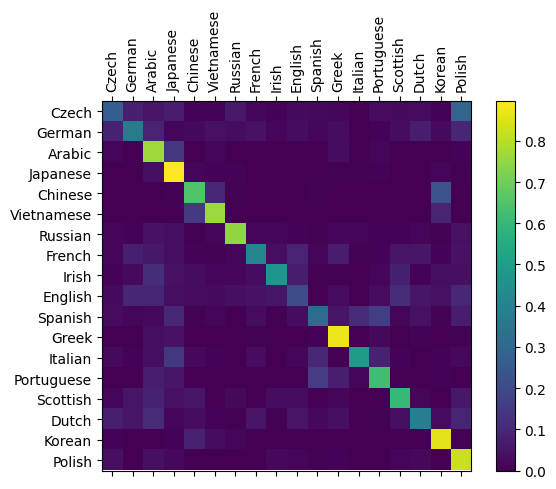

In [16]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000


# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output


# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([""] + all_categories, rotation=90)
ax.set_yticklabels([""] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [17]:
def predict(input_line, n_predictions=3):
    print("\n> %s" % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print("(%.2f) %s" % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


predict("Dovesky")
predict("Jackson")
predict("Satoshi")


> Dovesky
(-0.39) Russian
(-1.32) Czech
(-3.72) English

> Jackson
(-0.67) Scottish
(-2.03) English
(-2.10) Russian

> Satoshi
(-0.63) Japanese
(-1.48) Polish
(-1.88) Arabic


In [18]:
predict("Deependu")
predict("Nepali")


> Deependu
(-1.10) French
(-1.82) German
(-1.90) Dutch

> Nepali
(-0.98) Arabic
(-1.12) Italian
(-2.15) Polish


## Save model

In [19]:
import torch

torch.save(rnn, "rnn.pth")
torch.save(rnn.state_dict(), "rnn_state_dict.pth")

---

## load model

In [20]:
import torch

my_loaded_rnn_model = torch.load("rnn.pth")

my_loaded_rnn_model

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [21]:
my_loaded_rnn_model_with_state_dict = torch.load("rnn_state_dict.pth")

In [22]:
my_loaded_rnn_model_with_state_dict

OrderedDict([('i2h.weight',
              tensor([[-0.1186,  0.0208,  0.0456,  ..., -0.0008, -0.0880, -0.0063],
                      [ 0.0341,  0.0733,  0.1771,  ..., -0.0148,  0.0531, -0.0929],
                      [-0.2279,  0.0754, -0.2669,  ...,  0.0497, -0.0657,  0.0284],
                      ...,
                      [-0.3043,  0.0292, -0.0949,  ..., -0.0077, -0.0067,  0.0219],
                      [ 0.3107,  0.0412, -0.3600,  ..., -0.0033, -0.0755, -0.1084],
                      [-0.0760, -0.0407, -0.0052,  ...,  0.0717,  0.0875,  0.0889]])),
             ('i2h.bias',
              tensor([ 0.0246, -0.0169,  0.1112, -0.0146,  0.0561,  0.0267,  0.1319,  0.0127,
                      -0.0108, -0.0158,  0.0828,  0.0404, -0.0653,  0.0053,  0.0681, -0.0448,
                      -0.0509, -0.0017, -0.0502,  0.0274,  0.0274, -0.0321,  0.0181,  0.0516,
                       0.0724,  0.0401,  0.1315, -0.0291, -0.0211,  0.0846, -0.1098, -0.0904,
                      -0.0542, -0.03

In [23]:
all_losses[:5]

[2.883557644367218,
 2.8575363569259644,
 2.818021274805069,
 2.7642511074543,
 2.6184724360108373]